In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import plotly.express as px

import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import files
math = files.upload()

Saving student-mat.csv to student-mat (1).csv


In [3]:
df = pd.read_csv('student-mat.csv', sep=';')
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,6,10,10


***Target Variable for Regression: Final Grade (G3)***

In [4]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['guardian'] = le.fit_transform(df['guardian'])

num_col = []
cat_col = []

for x in df.columns:
    if df[x].dtypes == 'int64':
        num_col.append(x)
    else:
        cat_col.append(x)

df_num = df[num_col]
df_cat = df[cat_col]

In [5]:
df_num['AvgGrade'] = (df_num.G1 + df_num.G2 + df_num.G3)/3
df_num['AvgGradebinned'] = pd.qcut(df_num['AvgGrade'], 3)

# Eda

## School and Absences

In [98]:
def ever_absent(x):
    if x > 0:
        x = 1
    elif x == 0:
        x = 0
    return x
df['ever_absent'] = df.absences.map(ever_absent)
df['absence_binned'] = pd.qcut(df.absences, 5, duplicates='drop')
df.ever_absent.value_counts()

1    280
0    115
Name: ever_absent, dtype: int64

In [99]:
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
formula = 'G3 ~ absence_binned'
lm = ols(formula, df).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                     sum_sq     df        F    PR(>F)
absence_binned   219.316651    3.0  3.55058  0.014608
Residual        8050.592209  391.0      NaN       NaN


    ANOVA Analysis results
    1. The amount of absences that a student has, when grouped into 5 different categories from 'rarely absent' to 'frequently absent', seem to have an effect on the final grade of the student

SpearmanrResult(correlation=0.017730669122425113, pvalue=0.7253626110680622)


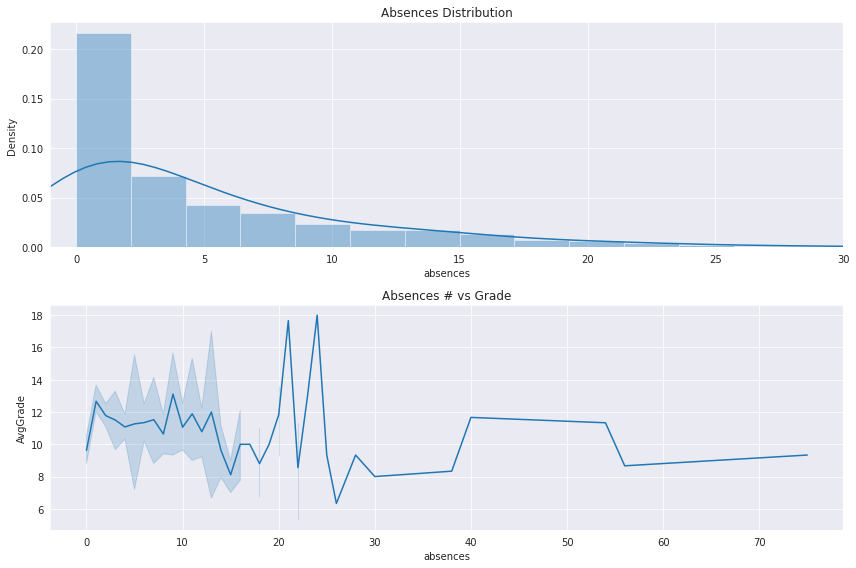

In [76]:
fig, ax = plt.subplots(2, figsize=(12, 8))
sns.distplot(df_num.absences, ax=ax[0])
ax[0].set_title('Absences Distribution')
ax[0].set_xlim(-1,30)

sns.lineplot(x=df_num.absences, y=df_num['AvgGrade'], ax=ax[1])
ax[1].set_title('Absences # vs Grade')
plt.tight_layout()

from scipy.stats import spearmanr
print(spearmanr(df['absences'], df['G3']))

Absences has little to no correlation to final grade

## Mother and Father's Jobs, Family Relationship, Guardianship

### Family Relationship

                sum_sq     df         F    PR(>F)
C(famrel)    33.573245    4.0  0.397433  0.810487
Residual   8236.335616  390.0       NaN       NaN


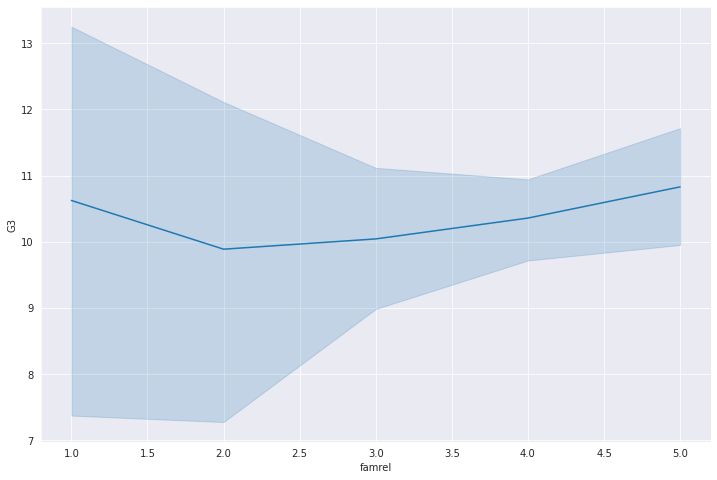

In [91]:
fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(df['famrel'], df['G3'], ax=ax)

from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
formula = 'G3 ~ C(famrel)'
lm = ols(formula, df).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

    ANOVA Analysis results
    1. Family Relationship strength does not seem to have an effect on the final grade of the student

### Mother and Father Occupations

               sum_sq     df        F    PR(>F)
C(Mjob)    306.643668    4.0  3.75446  0.005195
Residual  7963.265193  390.0      NaN       NaN


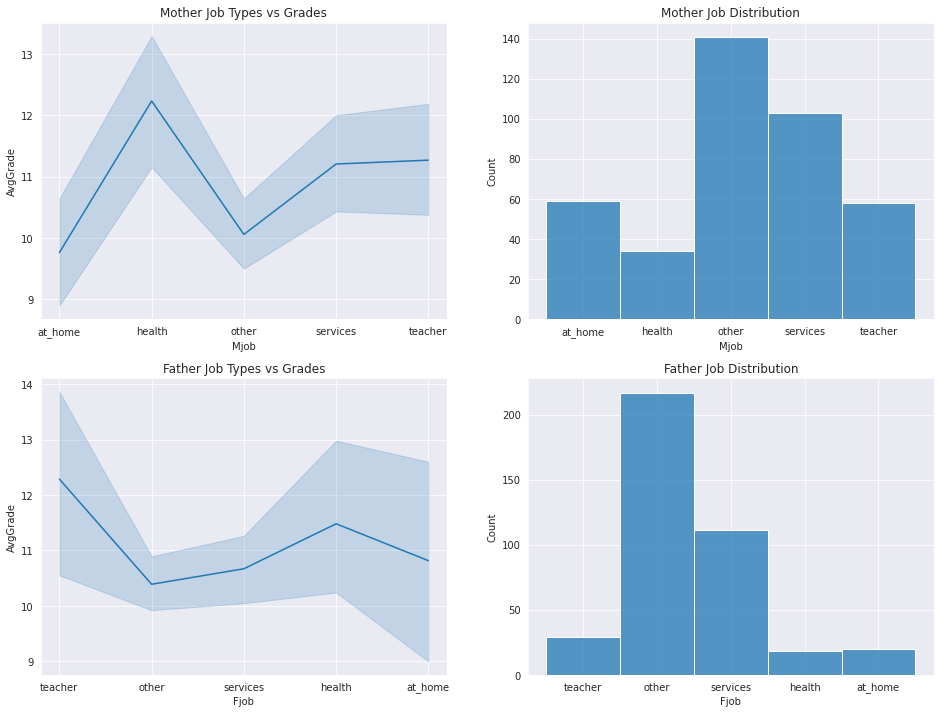

In [84]:
fig, ax = plt.subplots(2, 2, figsize=(16,12))

sns.lineplot(data=df, x='Mjob', y=df_num.AvgGrade, ax=ax[0][0])
ax[0][0].set_title('Mother Job Types vs Grades')
sns.histplot(data=df, x='Mjob', ax=ax[0][1])
ax[0][1].set_title('Mother Job Distribution')

sns.lineplot(data=df, x='Fjob', y=df_num.AvgGrade, ax=ax[1][0])
ax[1][0].set_title('Father Job Types vs Grades')
sns.histplot(data=df, x='Fjob', ax=ax[1][1])
ax[1][1].set_title('Father Job Distribution')

from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
formula = 'G3 ~ C(Mjob)'
lm = ols(formula, df).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

    ANOVA Analysis results
    1. The mother's occupation does have an effect on the final grade of the student
    2. The father's occupation does **NOT** have an effect on the final grade of the student

### Guardianship

Ttest_indResult(statistic=0.7075898045043748, pvalue=0.48019708894109325)

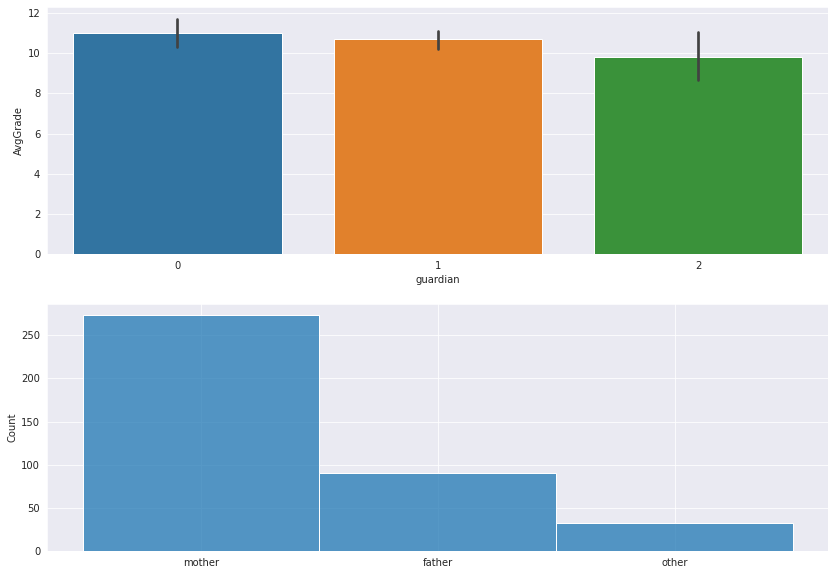

In [78]:
from scipy.stats import ttest_ind

fig, ax = plt.subplots(2,1, figsize=(14, 10))
sns.barplot(df['guardian'], df_num['AvgGrade'], ax=ax[0])
sns.histplot(le.inverse_transform(df['guardian']), ax=ax[1])
ttest_ind(np.array(df_num.AvgGrade[df_num.guardian == 0]), np.array(df_num.AvgGrade[df_num.guardian == 1]), equal_var=False)

The Welch's T-test shows that there is really no statistically significant different between the grades based on guardianship

## Time Allocation

In [ ]:
fig, ax = plt.subplots(4, figsize=(15,15))
sns.lineplot(x=df_num['studytime'], y=df_num['G3'], ax=ax[0])
ax[0].set_title('Study Time vs Average Grade')
ax[0].set_xlabel('Study Time')
ax[0].set_ylabel('Final Grade')

sns.lineplot(x=df_num['traveltime'], y=df_num['G3'], ax=ax[1])
ax[1].set_title('Travel Time vs Average Grade')
ax[1].set_xlabel('Travel Time')
ax[1].set_ylabel('Final Grade')

sns.lineplot(x=df_num['freetime'], y=df_num['G3'], ax=ax[2])
ax[2].set_title('Free Time vs Average Grade')
ax[2].set_xlabel('Free Time')
ax[2].set_ylabel('Final Grade')

sns.lineplot(x=df_num['goout'], y=df_num['G3'], ax=ax[3])
ax[3].set_title('Goout vs Average Grade')
ax[3].set_xlabel('Go Out')
ax[3].set_ylabel('Final Grade')

plt.tight_layout()
plt.show()


from scipy.stats import spearmanr
print('Study Time Spearman Test:, ', spearmanr(df_num['studytime'], df_num['AvgGrade']))
print('Travel Time Spearman Test:, ', spearmanr(df_num['traveltime'], df_num['AvgGrade']))
print('Free Time Spearman Test:, ', spearmanr(df_num['freetime'], df_num['AvgGrade']))
print('Go Out Spearman Test:, ', spearmanr(df_num['goout'], df_num['AvgGrade']))

In [ ]:
plt.bar(x=df['goout'], height=df['G3'])

    The time features that are monotonically correlated on a significant level according to the Spearman Correlation Test:
    1. Study Time
    2. Travel Time
    3. Go Out

    The time features that are NOT monotonically correlated on a significant level according to the Spearman Correlation Test:
    1. Free Time

## Alcohol Consumption

In [ ]:
fig, ax = plt.subplots(2, figsize=(16,12))
sns.lineplot(x=df['Dalc'], y=df['G3'], ax=ax[0])
sns.lineplot(x=df['Walc'], y=df['G3'], ax=ax[1])
ax[0].set_title('Weekday Alcohol Consumption vs Final Grade')
ax[1].set_title('Weekend Alcohol Consumption vs Final Grade')
plt.tight_layout()
plt.show()

print('Weekday Alcohol Consumption Spearman Test:, ', spearmanr(df['Dalc'], df['G3']))
print('Weekend Alcohol Consumption Spearman Test:, ', spearmanr(df['Walc'], df['G3']))

Both weekday and weekend alcohol consumption seem to have a correlation with the final grade, however weekend alcohol consumption is almost half as correlated to final grade vs weekday alcohol consumption

## Family Support, Family Relations, Guardian

In [ ]:
fig, ax = plt.subplots(2, figsize=(16,12))
sns.barplot(x=df['famsup'], y=df['G3'], ax=ax[0])
sns.lineplot(x=df['famrel'], y=df['G3'], ax=ax[1])

print('Study Time Spearman Test:, ', spearmanr(df['Dalc'], df['G3']))
print('Study Time Spearman Test:, ', spearmanr(df['Walc'], df['G3']))

# Modeling